## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## plot setting
plt.rcParams['font.family'] = 'Meiryo'
plt.style.use('ggplot')

## pandas setting
pd.set_option('display.max_columns', 500)

### Functions

In [3]:
def generate_data(_beta, _mu_x, _std_x, _mu_eps, _std_eps, _N, _P):
    eps = np.random.normal(_mu_eps, _std_eps, _N)
    X = np.random.normal(_mu_x, _std_x, size=(_N, _P))
    y = np.dot(X, _beta) + eps

    return y, X, eps

def split_train_test(_y, _X, _split_num):
    X_train, X_test = _X[:_split_num], _X[_split_num:]
    y_train, y_test = _y[:_split_num], _y[_split_num:]

    return X_train, X_test, y_train, y_test


def reg_ridge(y, X, penalty):
    k = X.shape[1]
    lh_mat = X.T @ X + penalty * np.identity(k)
    rh_mat = X.T @ y

    return np.linalg.solve(lh_mat, rh_mat)

def draw_bootstrap_sample(rng, X, y):
    sample_indices = np.arange(X.shape[0])
    bootstrap_indices = rng.choice(sample_indices,
                                   size=sample_indices.shape[0],
                                   replace=True)
    return X[bootstrap_indices], y[bootstrap_indices]

def compute_bias_variance_decomposition(estimator, true_estimator,
                         X_train, y_train, X_test, y_test,
                         iter_num=200, random_seed=42,
                         **fit_params):

    rng = np.random.RandomState(random_seed)
    all_pred = np.zeros((iter_num, y_test.size), dtype=np.float64)
    y_true = X_test @ true_estimator

    for i in range(iter_num):
        X_boot, y_boot = draw_bootstrap_sample(rng, X_train, y_train)
        estimate = estimator(y_boot, X_boot, **fit_params)
        y_pred = X_test @ estimate
        all_pred[i] = y_pred

    mse = np.apply_along_axis(
            lambda x:
            ((x - y_test)**2).mean(),
            axis=1,
            arr=all_pred).mean()

    
    main_predictions = np.mean(all_pred, axis=0)
    squared_bias = np.sum((main_predictions - y_true)**2) / y_true.size
    mean_variance = np.sum((main_predictions - all_pred)**2) / all_pred.size

    return mse, squared_bias, mean_variance

### Example: subset of small coefficients

In [4]:
## seed
np.random.seed(42)

## parameters
N = 100 # sample size
P = 30    # rank
mu_eps, std_eps = 0, 1
mu_x, std_x = 0, 1

## simulation data
### making coefficients
beta_1 = np.random.uniform(0.5, 1.0, 5)
beta_2 = np.random.uniform(-1.0, -0.5, 5)
beta_3 = np.zeros(20)
beta = np.concatenate([beta_1, beta_2, beta_3], 0)

### creating dataset
y, X, eps = generate_data(beta, mu_x, std_x, mu_eps, std_eps, N, P)

### dataの確認
df = pd.DataFrame(X).add_prefix('x_')
df['y'] = y
df.describe()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20,x_21,x_22,x_23,x_24,x_25,x_26,x_27,x_28,x_29,y
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.080646,0.120032,0.072134,0.007962,-0.142738,-0.008921,0.225309,0.035935,0.012524,-0.121158,0.143653,0.308474,-0.062046,-0.032253,-0.047615,0.187474,-0.057555,0.052214,-0.014684,0.094461,-0.097089,0.059498,0.048259,0.210704,0.172199,-0.167757,0.050794,0.024342,-0.176688,0.004482,-0.157278
std,0.947801,0.892194,0.958902,1.086897,1.065505,0.874876,1.075967,1.014251,1.000663,0.925160,0.920659,1.007120,0.930043,1.095257,0.874401,0.933254,0.969655,1.055934,0.926930,0.977009,0.919852,0.968671,0.967260,1.045845,0.931912,1.043841,1.017104,1.100309,1.074493,0.987361,2.542928
min,-2.562334,-1.643189,-2.499406,-2.940389,-3.241267,-1.645399,-2.211862,-1.616311,-2.553921,-2.219300,-1.951102,-2.152891,-2.488327,-2.921350,-2.424240,-2.198806,-2.747505,-2.591042,-2.635748,-2.991136,-2.650970,-2.872262,-2.703232,-2.848543,-2.121855,-2.296181,-3.019512,-2.246889,-2.696887,-2.832156,-5.921930
25%,-0.456862,-0.538811,-0.613723,-0.639110,-0.833161,-0.660997,-0.474332,-0.701118,-0.616413,-0.822132,-0.477592,-0.255906,-0.561534,-0.771618,-0.640044,-0.531710,-0.745344,-0.632097,-0.620470,-0.537923,-0.638675,-0.539179,-0.634378,-0.383447,-0.556964,-1.028831,-0.588253,-0.769965,-0.998615,-0.752686,-1.984824
50%,0.200854,0.110765,0.119718,-0.046110,-0.170262,-0.083479,0.016409,-0.036034,0.028870,-0.179541,0.202676,0.283521,0.050126,-0.091685,-0.028554,0.226398,0.013979,0.043514,0.009320,0.077657,-0.024826,0.118532,0.073261,0.260532,0.187835,-0.102562,-0.044138,0.109401,-0.212969,0.019483,0.155908
75%,0.759112,0.687968,0.737704,0.596897,0.624757,0.502001,1.026313,0.637617,0.622661,0.451102,0.833913,0.850775,0.573076,0.743989,0.495078,0.758230,0.610440,0.772528,0.574114,0.639005,0.544474,0.853074,0.683596,0.919555,0.728845,0.683447,0.685974,0.681947,0.559589,0.658727,1.342719
max,2.218780,2.411677,2.412615,2.558199,2.088375,2.463242,2.620793,3.193108,2.170943,1.899882,3.078881,3.852731,2.060748,2.985259,2.157308,2.579709,2.074083,2.632382,2.403416,3.137749,2.056544,2.163255,2.526932,2.693034,2.560085,2.601683,2.644343,3.926238,2.949094,2.252436,5.879878


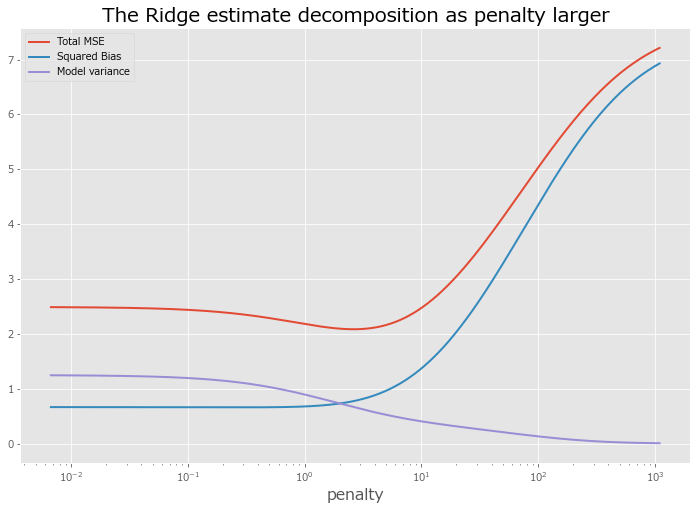

In [5]:
## simulation params
split_num = 70
iter_num = 1000
penalty_range = np.exp(np.linspace(-5, 7, iter_num))
result = np.empty((iter_num, 3))

## generate data
X_train, X_test, y_train, y_test = split_train_test(y, X, split_num)


for array_index, _penalty in enumerate(penalty_range):
    result[array_index,:] = compute_bias_variance_decomposition(estimator=reg_ridge, true_estimator=beta,
                                                                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                                                                iter_num=100, random_seed=42,
                                                                penalty = _penalty)

## plot
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(penalty_range,result,label = ['Total MSE', 'Squared Bias', 'Model variance'],lw=2)
ax.set_title('The Ridge estimate decomposition as penalty larger', fontsize=20)
ax.set_xlabel('penalty', fontsize=16)
ax.set_xscale('log')
ax.legend();
    
